# Overfitting, Regularization, and Information Criteria

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pymc3 as pm
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.special import logsumexp
import statsmodels.formula.api as smf 
%matplotlib inline

In [3]:
sns.set()

## The Problem with Parameters

### 6.1

In [4]:
sppnames = ["afarensis", "africanus", "habilis", "boisei", "rudolfensis", "ergaster", "sapiens"]
brainvolcc = [438, 452, 612, 521, 752, 871, 1350]
masskg = [37.0, 35.5, 34.5, 41.5, 55.5, 61.0, 53.5]
d = pd.DataFrame({"species": sppnames,
                  "brain": brainvolcc,
                  "mass": masskg})

### 6.2

In [5]:
m6_1 = smf.ols("brain ~ mass", data=d).fit()

### 6.3

In [6]:
1 - m6_1.resid.var()/d["brain"].var()

0.490158047949084

### 6.4

In [7]:
m6_2 = smf.ols('brain ~ mass + I(mass**2)', data=d).fit()

### 6.5

In [8]:
m6_3 = smf.ols("brain ~ mass + I(mass**2) + I(mass**3)", data=d).fit()
m6_4 = smf.ols("brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4)", data=d).fit()
m6_5 = smf.ols("brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4) + I(mass**5)", data=d).fit()
m6_6 = smf.ols("brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4) + I(mass**5) + I(mass**6)", data=d).fit()

### 6.6

In [9]:
m6_7 = smf.ols('brain ~ 1', data=d).fit()

### 6.7

In [10]:
d_new = d.drop(d.index[-1])

### 6.8

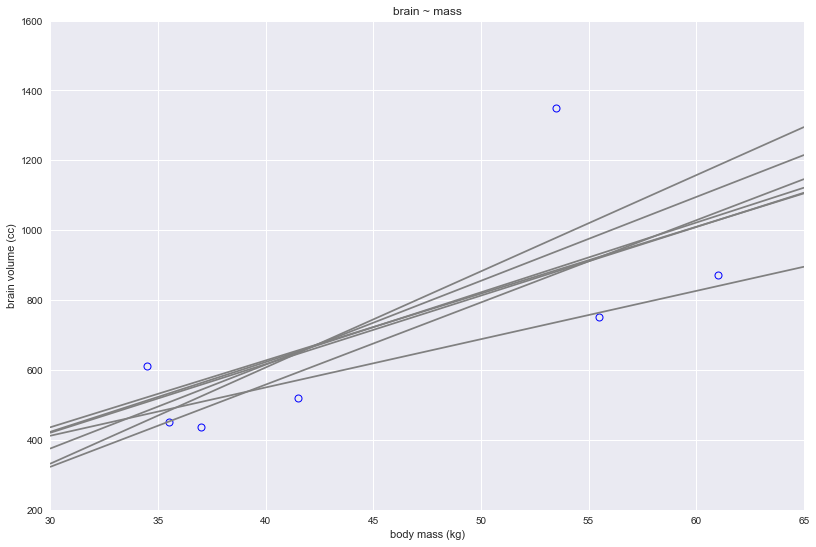

In [11]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
xs = pd.DataFrame({"mass": np.linspace(30, 65, 30)})

ax.plot(d["mass"], d["brain"], "o", mew=1.0, mec="b", mfc="None")
for i in range(len(d)):
    d_new = d.drop(d.index[i])
    m0 = smf.ols("brain ~ mass", data=d_new).fit()
    ax.plot(xs, m0.predict(xs), color="grey")

ax.set_xlim(30, 65)
ax.set_ylim(200, 1600)
ax.set_xlabel("body mass (kg)")
ax.set_ylabel("brain volume (cc)")
ax.set_title("brain ~ mass");

## Information Theory and Model Performance

### 6.9

In [12]:
p = np.array([0.3, 0.7])
-np.sum(p * np.log(p))

0.6108643020548935

### 6.10

In [13]:
m6_1 = smf.ols("brain ~ mass", data=d).fit()
-2 * m6_1.llf

94.92498968588757

### 6.11

In [14]:
d["mass_s"] = (d["mass"] - d["mass"].mean())/d["mass"].std()

with pm.Model() as m6_8:
    a = pm.Normal("a", mu=np.mean(d["brain"]), sd=10)
    b = pm.Normal("b", mu=0, sd=10)
    sigma = pm.Uniform("sigma", 0, np.std(d["brain"]) * 10)
    mu = pm.Deterministic("mu", a + b * d["mass_s"])
    brain = pm.Normal("brain", mu=mu, sd=sigma, observed=d["brain"])
    trace6_8 = pm.sample(draws=1000, tune=1000)
    
theta = pm.summary(trace6_8, varnames=["a", "b", "sigma"])["mean"]
dev = -2 * np.sum(stats.norm.logpdf(d["brain"], loc=theta["a"] + theta["b"]*d["mass_s"], scale=theta["sigma"]))
dev

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1188.75draws/s]


100.18546068142672

### 6.12

Implementing [this](https://github.com/rmcelreath/rethinking/blob/a309712d904d1db7af1e08a76c521ab994006fd5/R/sim_train_test.R) function in python, but largely copying over from [here](https://github.com/pymc-devs/resources/blob/master/Rethinking/Chp_06.ipynb)

In [15]:
def sim_train_test(N=20, k=3, rho=[0.15, -0.14], b_sigma=100):
    n_dim = 1 + len(rho)

    if n_dim < k:
        rho = np.pad(rho, (0, k - n_dim), "constant")
        n_dim = k
    
    Rho = np.diag(np.ones(n_dim))
    Rho[0, 1:] = rho
    Rho[1:, 0] = rho
    
    x_train = stats.multivariate_normal.rvs(cov=Rho, size=N)
    x_test = stats.multivariate_normal.rvs(cov=Rho, size=N)
   
    mm_train = np.concatenate([np.ones((N, 1)), x_train[:, 1:k]], axis=1)
    mm_test = np.concatenate([np.ones((N, 1)), x_test[:, 1:k]], axis=1)

    with pm.Model() as m_sim:
        vec_V = pm.MvNormal('vec_V', mu=0, cov=b_sigma * np.eye(k), shape=(1, k))
        mu = pm.Deterministic('mu', pm.math.dot(mm_train, vec_V.T))
        y = pm.Normal('y', mu=mu, sd=1, observed=x_train[:, 0])
        tracem_sim = pm.sample()

    vec = np.array(pm.summary(tracem_sim)['mean'][:k]).reshape(k, -1)
    dev_train = -2 * sum(stats.norm.logpdf(x_train[:, 0], loc=np.matmul(mm_train, vec), scale=1))
    dev_test = -2 * sum(stats.norm.logpdf(x_test[:, 0], loc=np.matmul(mm_test, vec), scale=1))
    return np.mean(dev_train), np.mean(dev_test)

### 6.13

In [16]:
deviances = []
for k in range(1, 6):
    for _ in range(10):
        dev_train, dev_test = sim_train_test(k=k)
        deviances.append((k, dev_train, dev_test))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:01<00:00, 1197.89draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:01<00:00, 1084.96draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:01<00:00, 1294.86draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:01<00:00, 1284.33draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains: 100%|███████

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:02<00:00, 814.79draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:02<00:00, 821.11draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:02<00:00, 691.01draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:02<00:00, 856.83draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:02<00:00, 743.58draws/s]
Auto-assigning NUTS sampler...
Initi

### 6.14

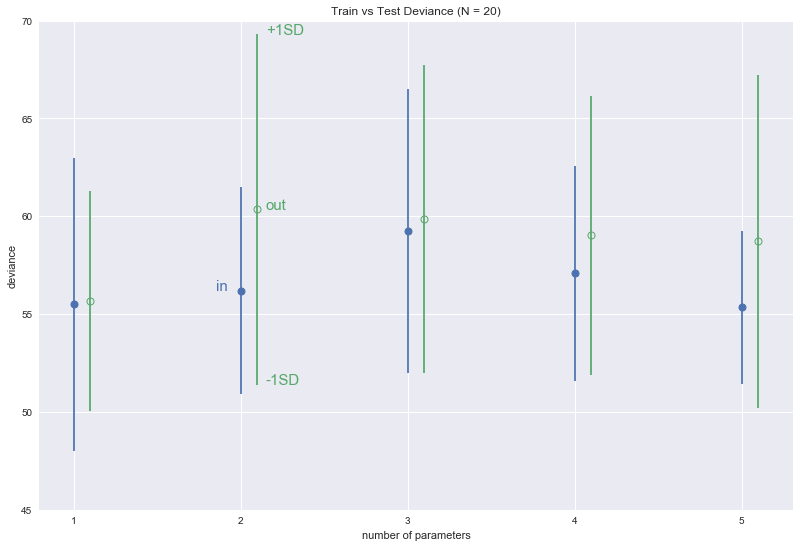

In [17]:
data = (pd.DataFrame(deviances, columns=["k", "dev_train", "dev_test"])
        .groupby("k")
        .agg({"dev_train": [np.mean, np.std],
              "dev_test": [np.mean, np.std]}))

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)

ax.errorbar(x=data.index, y=data["dev_train", "mean"], fmt="o", yerr=data["dev_train", "std"],
           mew=1.0, mec="C0");
ax.errorbar(x=data.index +0.1, y=data["dev_test", "mean"], fmt="o", yerr=data["dev_test", "std"],
           mew=1.0, mec="C1", mfc="None");
ax.set_xlabel("number of parameters")
ax.set_ylabel("deviance")
ax.set_title("Train vs Test Deviance (N = 20)")
plt.text(2 - 0.15, data.loc[2]["dev_train", "mean"], "in", color="C0", fontsize=15)
plt.text(2 + 0.15, data.loc[2]["dev_test", "mean"], "out", color="C1", fontsize=15)
plt.text(2 + 0.15, data.loc[2]["dev_test", "mean"] + data.loc[2]["dev_test", "std"],
         "+1SD", color="C1", fontsize=15)
plt.text(2 + 0.15, data.loc[2]["dev_test", "mean"] - data.loc[2]["dev_test", "std"],
         "-1SD", color="C1", fontsize=15)
ax.set_ylim(45, 70);

## Regularization

## Information Criteria

### 6.15

In [18]:
cars = pd.read_csv('Data/cars.csv', sep=',')

with pm.Model() as m6_9:
    sigma = pm.Uniform("sigma", 0, 30)
    b = pm.Normal("b", mu=0, sd=10)
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a + b*cars["speed"])
    dist = pm.Normal("dist", mu=mu, sd=sigma, observed = cars["dist"])
    trace6_9 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, b, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:04<00:00, 885.46draws/s]


### 6.16

In [19]:
n_samples = 1000

acc = []
for _ in range(n_samples):
    mu = trace6_9["a"][0] + trace6_9["b"][0]*cars["speed"]
    sigma = trace6_9["sigma"][0]
    acc.append(stats.norm.logpdf(cars["dist"], loc=mu, scale=sigma))
ll = np.array(acc)

### 6.17

In [20]:
n_cases = len(cars)
lppd = logsumexp(ll, axis=0) - np.log(n_samples)

### 6.18

In [21]:
pWAIC = np.var(ll, axis=0)

### 6.19

In [22]:
-2 * (sum(lppd) - sum(pWAIC))

413.3394996944876

### 6.20

In [23]:
waic_vec = -2 * (lppd - pWAIC)
np.sqrt(n_cases * np.var(waic_vec))

11.48423924540502